# **SEBAL Analysis of Daily ETa Rasters**

In [1]:

# Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import variation,zscore
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import random
import seaborn as sns
import itertools

# Loading geocube to raterize vector polygons (https://github.com/corteva/geocube)
from geocube.api.core import make_geocube

import spyndex
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat




import glob
import os
import os.path
import sys

In [2]:
# Import SPAEF Function from https://github.com/cuneyd/spaef
import SPAEF_metric as sp

In [3]:
# import required modules
import numpy as np
from scipy.stats import variation,zscore
import math
######################################################################################################################
def filter_nan(s,o):
    data = np.transpose(np.array([s.flatten(),o.flatten()]))
    data = data[~np.isnan(data).any(1)]
    return data[:,0], data[:,1]
######################################################################################################################
def SPAEF(s, o):
    #remove NANs    
    s,o = filter_nan(s,o)
    
    bins_float=np.around(math.sqrt(len(o)),0)
    bins=int(bins_float)
    #compute corr coeff
    alpha = np.corrcoef(s,o)[0,1]
    #compute ratio of CV
    beta = variation(s)/variation(o)
    #compute zscore mean=0, std=1
    o=zscore(o)
    s=zscore(s)
    #compute histograms
    hobs,binobs = np.histogram(o,bins)
    hsim,binsim = np.histogram(s,bins)
    #convert int to float, critical conversion for the result
    hobs=np.float64(hobs)
    hsim=np.float64(hsim)
    #find the overlapping of two histogram      
    minima = np.minimum(hsim, hobs)
    #compute the fraction of intersection area to the observed histogram area, hist intersection/overlap index   
    gamma = np.sum(minima)/np.sum(hobs)
    #compute SPAEF finally with three vital components
    spaef = 1- np.sqrt( (alpha-1)**2 + (beta-1)**2 + (gamma-1)**2 )  

    return spaef, alpha, beta, gamma
######################################################################################################################

In [4]:
# Insert Start of data directory 
# path_data = "../../DATA_MesoHyd_MA-SEBAL/"   # Path data SC_UL
path_data = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/" # Path data NICOLAS-PC



In [5]:
# Set date(s) of modelling/data retrieval
# date = "2015-07-04"  # Initial LS Picture
date = "2018-11-17"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)


# Date in meteo_raster_daily Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)


# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_").replace("_", "_")
print("Date WASIM =", date_wasim)


# Date in ETp-FAO56-Raster Path Format
date_etp = date.date()
date_etp = date_etp.strftime('%Y_%m_%d').replace("_0", "-").replace("_", "-")
print("Date ETp =", date_etp)


# Date SSEB Format
date_SSEB = date.date()
date_SSEB = date_SSEB.strftime('%Y_%m_%d').replace("-", "_")
print("Date SSEB =", date_SSEB)

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)


Date normal = 2018-09-30 00:00:00
Date INTERMET = 2018-09-30
Date WASIM = 2018_9_30
Date ETp = 2018-9-30
Date SSEB = 2018_09_30
Date Landsat = 20180930


# Import Data

### Import Catchment Shapes

In [6]:
# 0. Path for GeoTIFF
stack_name = "LS08_" + date_LS + ".tif"
stack_path = path_data + "Processed/LANDSAT/LS_Processed/" + stack_name

# Load Shapefile for Catchments
path_shapeA = path_data + "Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = path_data + "Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

### Import SEBAL ETa Map

In [7]:
# Export ETa_day Raster 
export_path = path_data + "Processed/export/eta_day/ETa_day_" + date_SSEB + ".tif"


In [8]:
eta_day = rxr.open_rasterio(export_path, masked = True).squeeze()

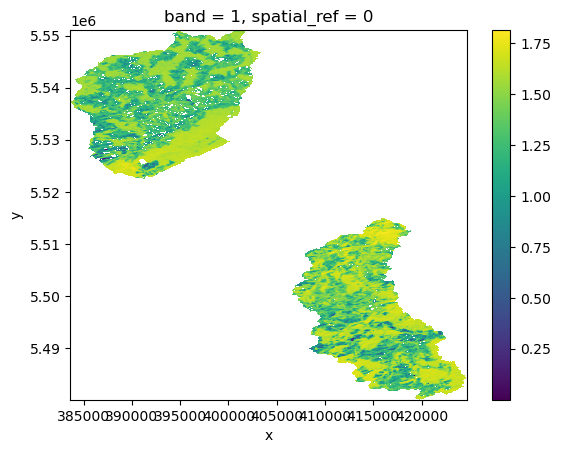

In [9]:
eta_day.plot()

### Import CORINE Land Cover Map

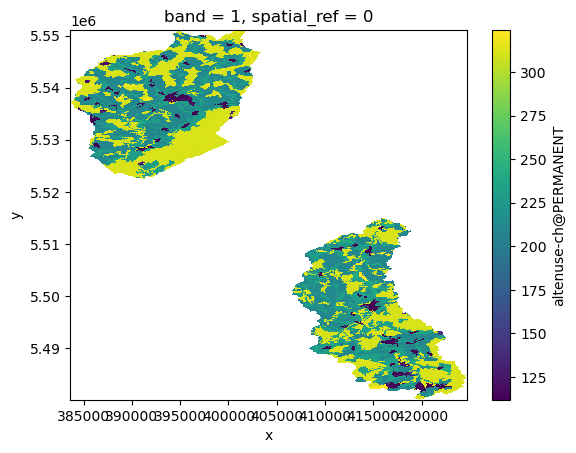

In [10]:
# Open Corine Land Use Maps for both catchments
path_LUA = path_data + "Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = path_data + "Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()

# Merge raster
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match

LU_mosaic.plot()


In [11]:
print(np.unique(LU_mosaic))
print(len(np.unique(LU_mosaic)))

[112. 121. 131. 132. 142. 211. 221. 231. 242. 243. 311. 312. 313. 322.
 324.  nan]
16


In [12]:
# Combine with Land Cover Key Table
LU_table_path = "../../data/clc_legend.csv"
LU_table = pd.read_csv(LU_table_path) #delimiter = "\t", header = [3]
#print(LU_table)

LU_agri = [211, 212, 221, 222, 223, 241, 242, 243, 244]
LU_bare = [331, 332, 333, 334, 131]
LU_grass = [231, 321, 322, 323, 324, 411, 412]
LU_urban = [111, 112, 121, 122, 123, 124, 132, 133, 141, 142]
LU_forest = [311, 312, 313]
LU_water = [511, 512, 335]

# Create filters from Land Use classes
agri_filter = np.isin(LU_mosaic.values, LU_agri)
bare_filter = np.isin(LU_mosaic.values, LU_bare)
grass_filter = np.isin(LU_mosaic.values, LU_grass)
urban_filter = np.isin(LU_mosaic.values, LU_urban)
forest_filter = np.isin(LU_mosaic.values, LU_forest)
water_filter = np.isin(LU_mosaic.values, LU_water)

### Results Lists

In [13]:
# Full regression
WASIM_fullreg = []
SSEB_fullreg = []
EEFlux_fullreg = []

# Agri
WASIM_agri = []
SSEB_agri = []
EEFlux_agri = []

# Bare Soil
WASIM_bare = []
SSEB_bare = []
EEFlux_bare = []

# Grass
WASIM_grass = []
SSEB_grass = []
EEFlux_grass = []

# Urban
WASIM_urban = []
SSEB_urban = []
EEFlux_urban = []

# Forest
WASIM_forest = []
SSEB_forest = []
EEFlux_forest = []

# WASIM ETa Raster

### Load data

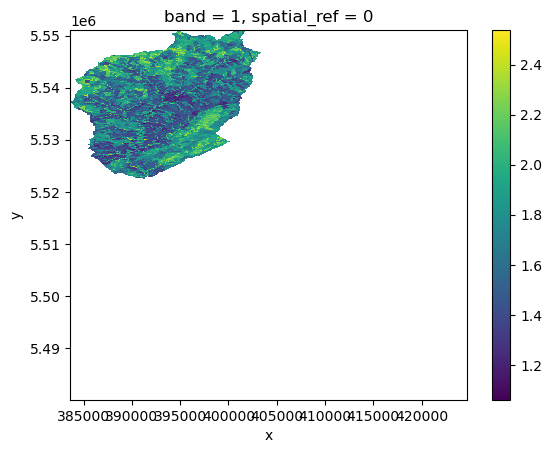

In [14]:
# Open WASIM Raster
path_wasim_kelle = path_data + "Original/WASIM_raster/etr_kelle_" + date_SSEB + ".tif"
wasim_kelle = rxr.open_rasterio(path_wasim_kelle, masked = True).squeeze()

# Merge raster
#LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
wasim = wasim_kelle # + merged wasim altenbamberg
wasim.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = wasim
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

wasim = xds_repr_match

wasim.plot()

### Scatterplot, simple statistics

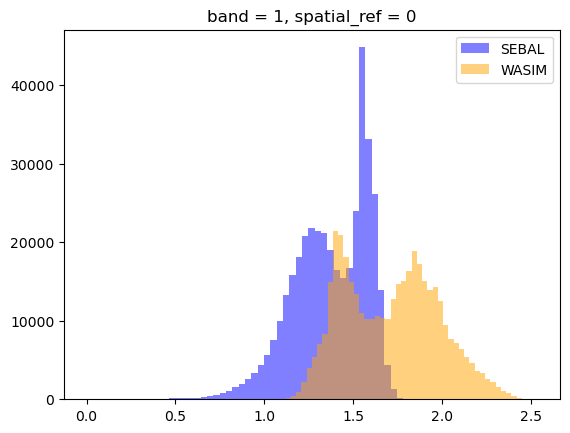

In [15]:
eta_kelle = eta_day.rio.clip(shape_kellen.geometry, all_touched = True)

eta_kelle.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
wasim.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "WASIM")
plt.legend(loc='upper right')
plt.show()

Slope: 0.6195618564683112
Intercept: 0.8698868363352817
R-squared value: 0.24256422249250437
P-value: 0.0
Standard error: 0.0017562558374133647


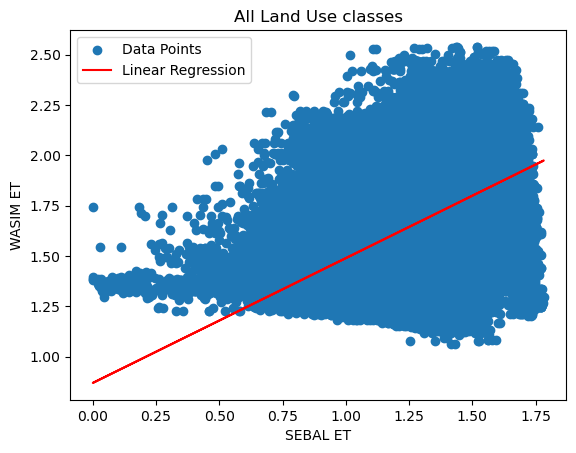

In [16]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Append results to list
WASIM_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))



### Statistics grouped by Land Use

https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html

Slope: -0.03363366207653731
Intercept: 1.5647026618495348
R-squared value: 0.0013036118310161221
P-value: 4.055319068613877e-39
Standard error: 0.002569716973557774


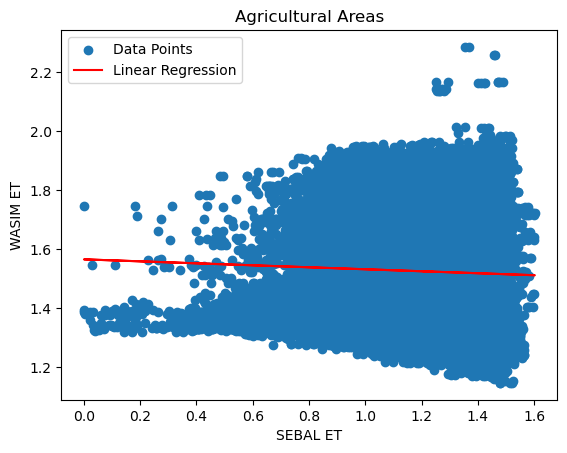

In [17]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(agri_filter).values
y_values = wasim.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.08791832099698892
Intercept: 1.8311930800750698
R-squared value: 0.0035083480527693333
P-value: 4.852386027803809e-62
Standard error: 0.005284701470856981


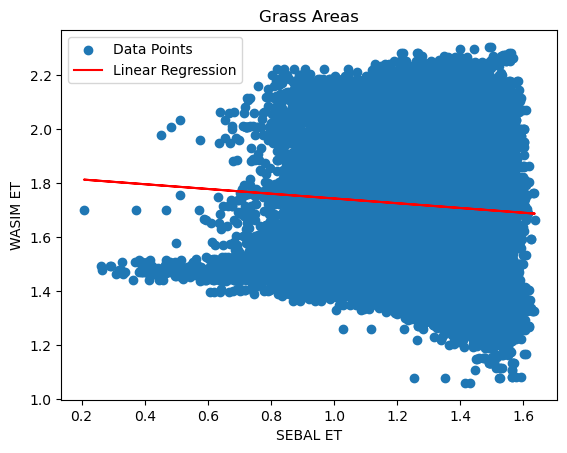

In [18]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(grass_filter).values
y_values = wasim.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.4197847444898204
Intercept: 2.575740278910498
R-squared value: 0.03854526071059263
P-value: 0.0
Standard error: 0.005199640960535405


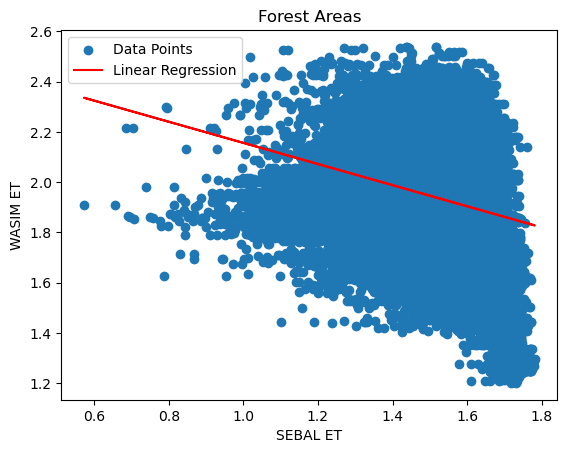

In [19]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(forest_filter).values
y_values = wasim.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.037809886839467725
Intercept: 1.375207469076548
R-squared value: 0.0032400552949885908
P-value: 0.2608855083021843
Standard error: 0.033580886103223885


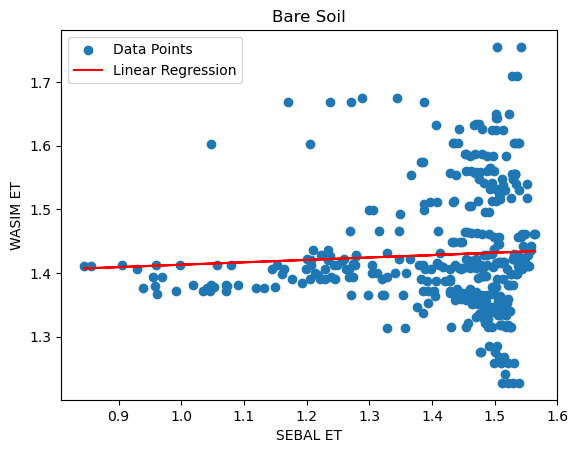

In [20]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(bare_filter).values
y_values = wasim.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.03814740460326133
Intercept: 1.3652109473481648
R-squared value: 0.005499453000563079
P-value: 1.072322731023326e-20
Standard error: 0.004083574671936065


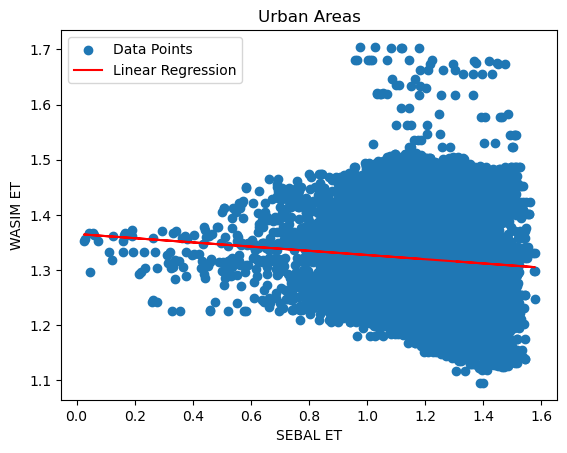

In [21]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(urban_filter).values
y_values = wasim.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_urban.extend((slope, intercept, r_value**2, p_value, std_err))

### SPAEF WASIM

In [22]:
SPAEF(wasim.values, eta_day.values)

(0.12084351875539234,
 0.49250809383451194,
 1.0040777760180815,
 0.2821201664389325)

# SSEB Raster

### Load data

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\Landsat8_MesoHyd_2018_09_30_ETa_SSEB_Alten_v2.tif', 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\Landsat8_MesoHyd_2018_09_30_ETa_SSEB_Kellen_v2.tif']


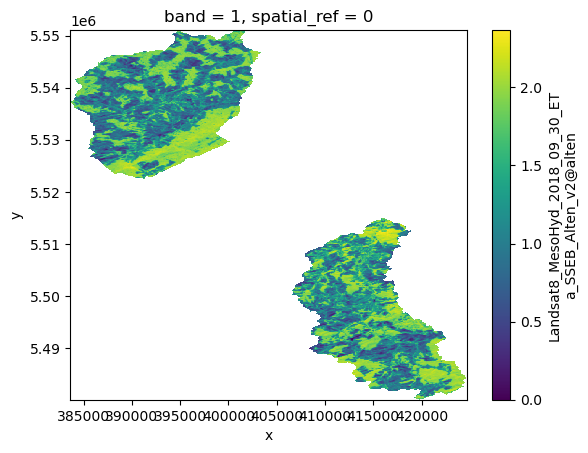

In [23]:
# DATA FROM SSEB

# Date in SSEB-Raster Path Format with time (hour)

# Create Path for recursive file search based on defined date
path_SSEB = path_data + "Original/SSEB/"
pattern = f"*{date_SSEB}*.tif"
paths_SSEB = sorted(glob.glob(os.path.join(path_SSEB, "**", pattern), recursive=True))
print(paths_SSEB)

# Combine both Rasters
raster_0 = rxr.open_rasterio(paths_SSEB[0]).squeeze()
raster_1 = rxr.open_rasterio(paths_SSEB[1]).squeeze()
SSEB_raster = merge_arrays(dataarrays = [raster_0, raster_1], nodata = np.nan)
SSEB_raster.rio.write_crs("epsg:32632", inplace=True)

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = SSEB_raster
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

SSEB_raster = xds_repr_match

SSEB_raster.plot()

### Scatterplot, simple statistics

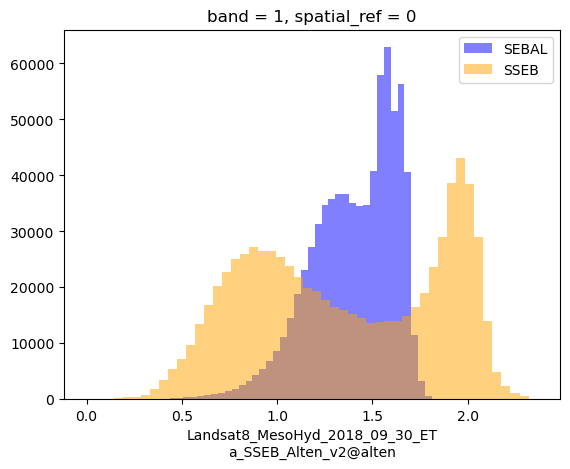

In [24]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
SSEB_raster.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "SSEB")
plt.legend(loc='upper right')
plt.show()

Slope: 2.0382601461953955
Intercept: -1.4926227227718838
R-squared value: 0.8161251174577677
P-value: 0.0
Standard error: 0.0011253850124499003


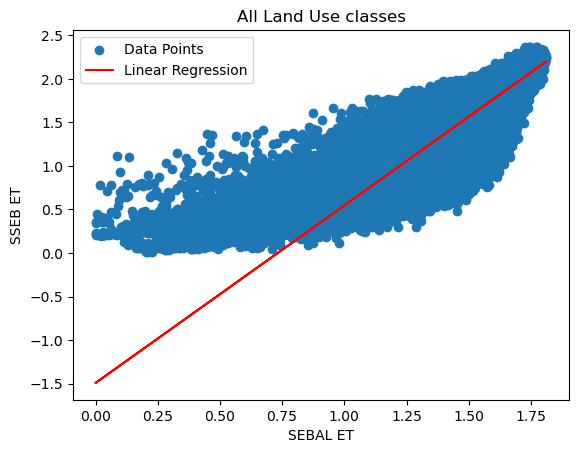

In [25]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.values
y_values = SSEB_raster.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Results into List
SSEB_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.3681908898020823
Intercept: -0.7974887243899331
R-squared value: 0.7062238303307345
P-value: 0.0
Standard error: 0.0017614218107484317


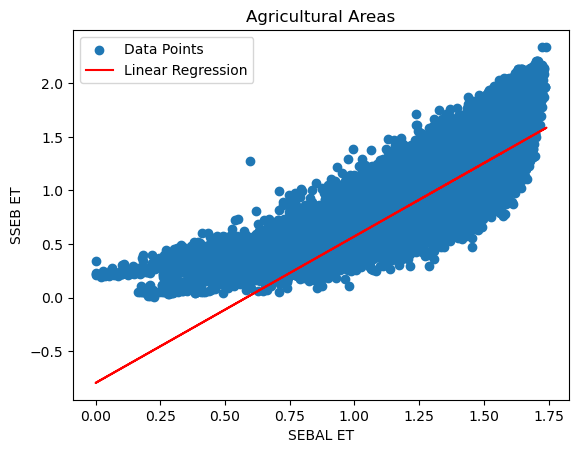

In [26]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(agri_filter).values
y_values = SSEB_raster.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.483560576681917
Intercept: -0.7638965441833914
R-squared value: 0.7766269358257231
P-value: 0.0
Standard error: 0.0019142854104193753


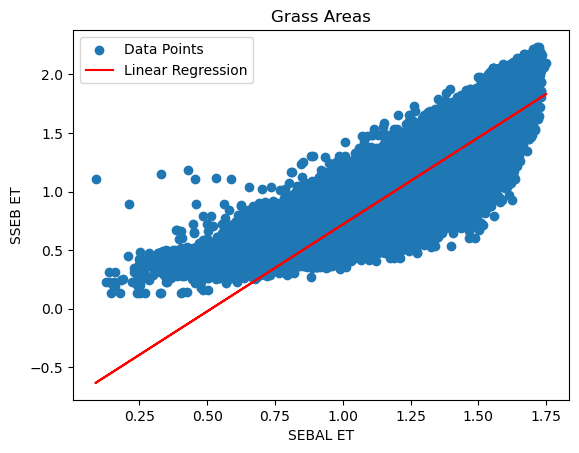

In [27]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(grass_filter).values
y_values = SSEB_raster.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.6735982656669441
Intercept: -0.777085441064459
R-squared value: 0.7039402605766351
P-value: 0.0
Standard error: 0.002049425362860377


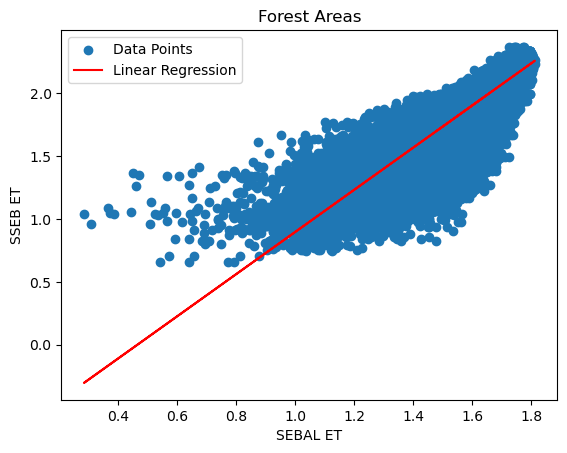

In [28]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(forest_filter).values
y_values = SSEB_raster.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.4290297754655035
Intercept: -0.7990494335570877
R-squared value: 0.5616837625054345
P-value: 7.570023059244137e-72
Standard error: 0.06392295152476214


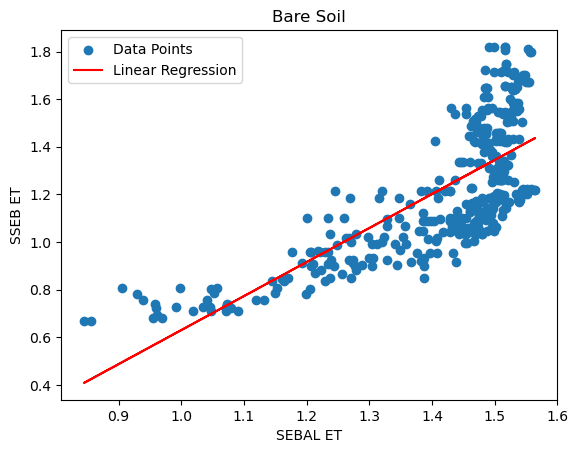

In [29]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(bare_filter).values
y_values = SSEB_raster.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.122984683427409
Intercept: -0.3025980723011772
R-squared value: 0.7435046604835438
P-value: 0.0
Standard error: 0.0035526390308391683


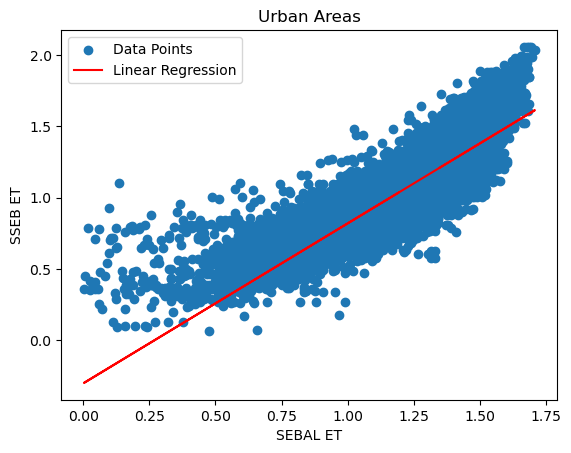

In [30]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(urban_filter).values
y_values = SSEB_raster.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_urban.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.307493957452245
Intercept: 1.2996328742171963
R-squared value: 0.3468063474723563
P-value: 0.0
Standard error: 0.0006657782699814501


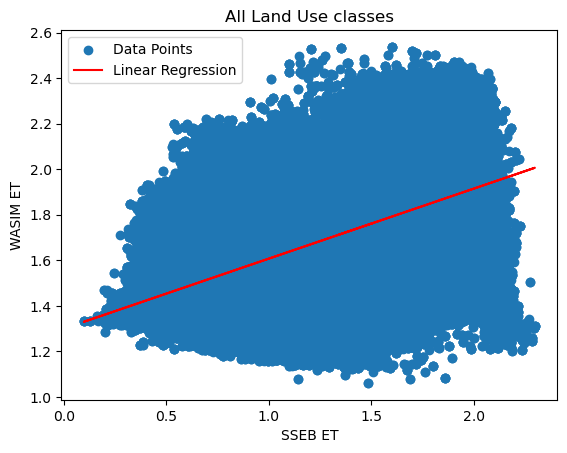

In [31]:
# WASIM AND SSEB
### Define Datasets 
title = "All Land Use classes"
x_name = "SSEB ET"
y_name = "WASIM ET"

x_values = SSEB_raster.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

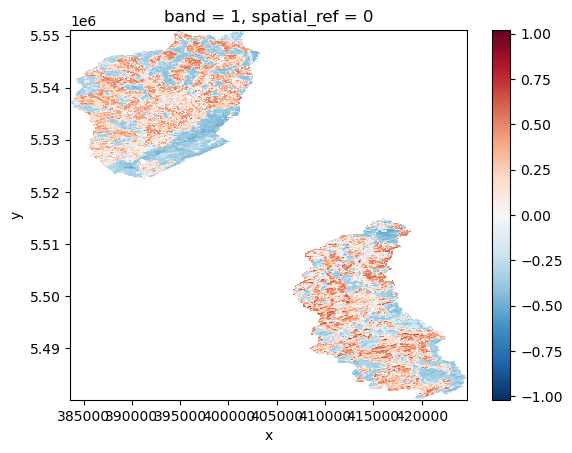

In [32]:
# Difference raster
diff = eta_day - SSEB_raster
diff.plot()

### SPAEF SSEB

In [33]:
SPAEF(eta_day.values, SSEB_raster.values)

(0.2639253476714025,
 0.9033964342733303,
 0.4317864572212819,
 0.5421714134171868)

In [34]:
SPAEF(SSEB_raster.values, eta_day.values)

(-0.3966706801563673,
 0.9033964342733304,
 2.3159596214188816,
 0.5421714134171868)

# EEFlux Raster

### Load data

In [35]:
# DATA FROM EEFlux

# Date in EEflux-Raster Path Format with time (hour)
date_eeflux = date_SSEB

# Create Path for recursive file search based on defined date
path_dir = path_data + "Original/EEFlux/"
pattern = f"*{date_eeflux}*.tif"
path_eeflux = sorted(glob.glob(os.path.join(path_dir, "**", pattern), recursive=True))
print(path_eeflux)

# Combine both Rasters
eeflux = rxr.open_rasterio(path_eeflux[0]).squeeze()
eeflux .rio.write_crs("epsg:32632", inplace=True)

# Clip raster by catchment vectors
eeflux_clip = eeflux.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = eeflux_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

eeflux = xds_repr_match

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/EEFlux\\eeflux_2018_09_30.tif']


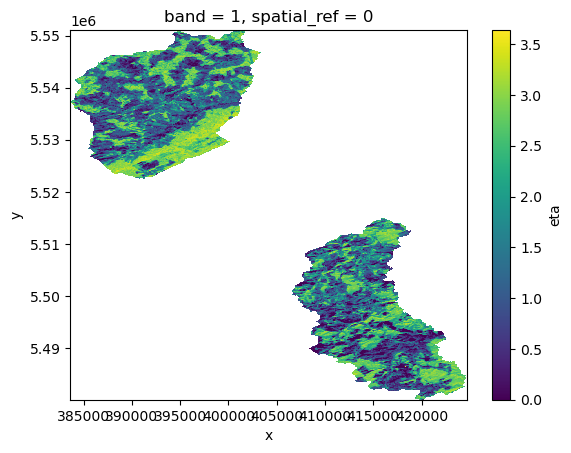

In [36]:
eeflux.plot()

### Scatterplot, simple statistics

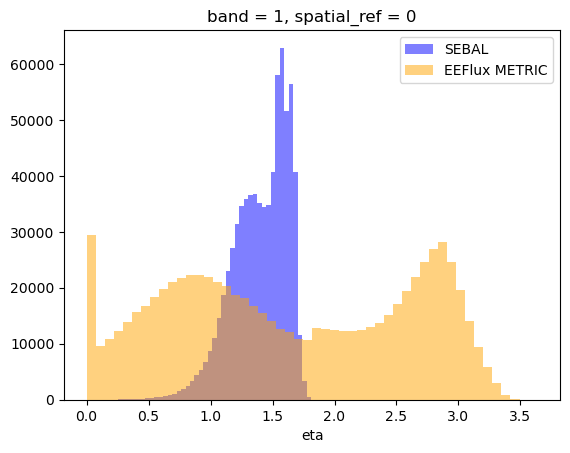

In [37]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
eeflux.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "EEFlux METRIC")
plt.legend(loc='upper right')
plt.show()

Slope: 3.855462087658236
Intercept: -3.767291878606415
R-squared value: 0.7863848499359585
P-value: 0.0
Standard error: 0.002337402882370258


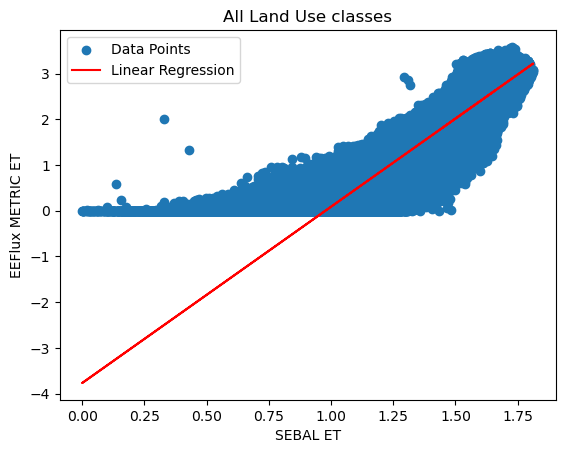

In [38]:
### Define Datasets 

title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.values
y_values = eeflux.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results in List
EEFlux_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))


Slope: 2.515816483325063
Intercept: -2.234592346442888
R-squared value: 0.6485985375450671
P-value: 0.0
Standard error: 0.003696343602543602


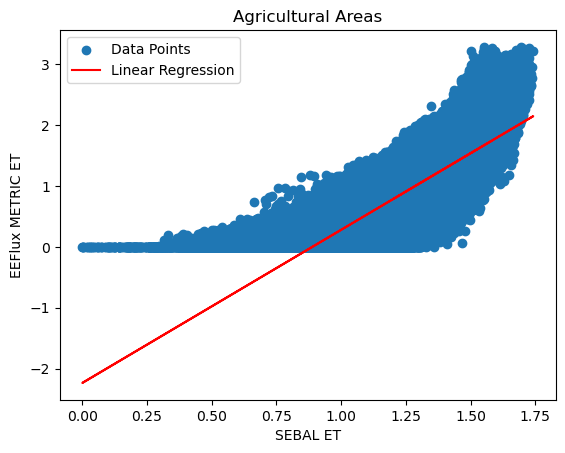

In [39]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(agri_filter).values
y_values = eeflux.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 2.966053779813031
Intercept: -2.7215446073141507
R-squared value: 0.6763372426090142
P-value: 0.0
Standard error: 0.004936691220130854


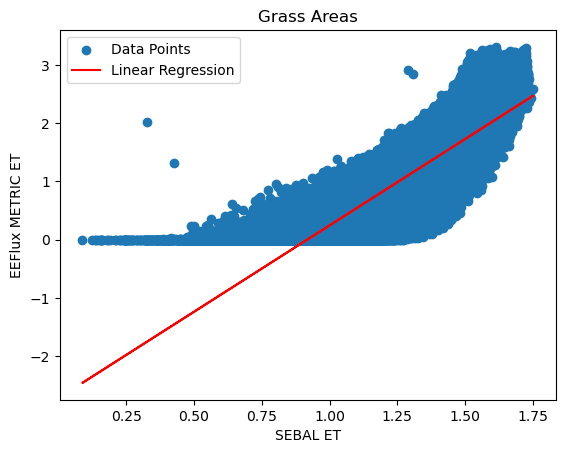

In [40]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(grass_filter).values
y_values = eeflux.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 3.8055651420762757
Intercept: -3.440658775084722
R-squared value: 0.5726172477334054
P-value: 0.0
Standard error: 0.006208040750091684


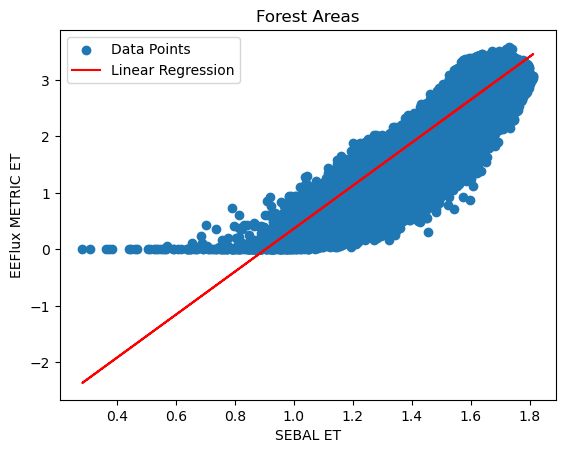

In [41]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(forest_filter).values
y_values = eeflux.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 4.054888368441335
Intercept: -4.376756871661723
R-squared value: 0.485669528175274
P-value: 2.8446784690130012e-58
Standard error: 0.21129893039926534


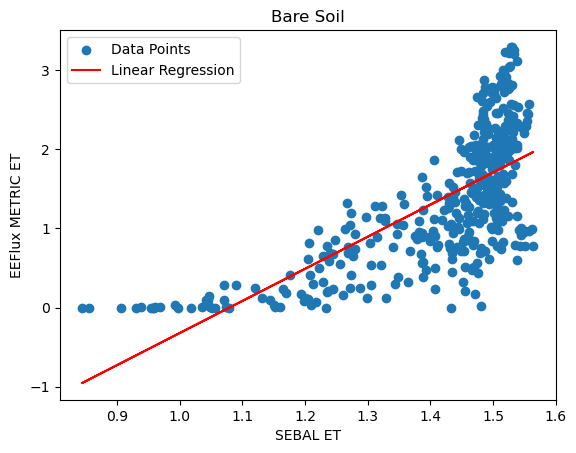

In [42]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(bare_filter).values
y_values = eeflux.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 2.2375605145644264
Intercept: -1.8983747265719697
R-squared value: 0.6406597774548318
P-value: 0.0
Standard error: 0.009025958551283467


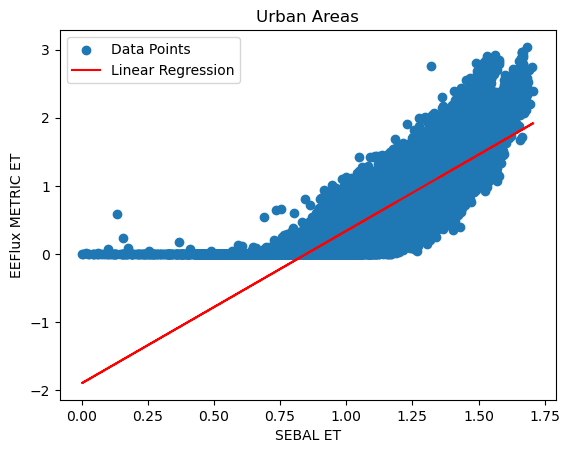

In [43]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(urban_filter).values
y_values = eeflux.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_urban.extend((slope, intercept, r_value**2, p_value, std_err))

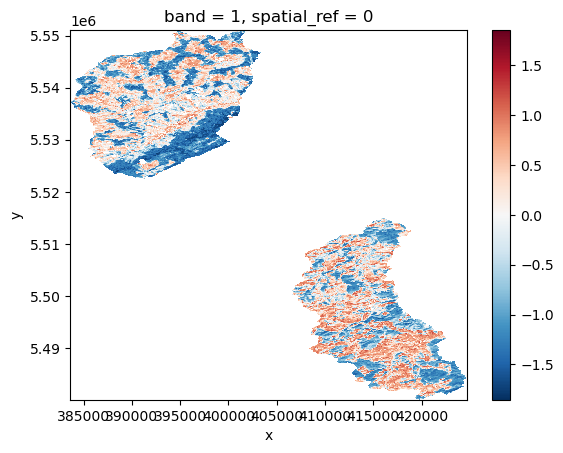

In [44]:
# Difference raster
diff = eta_day - eeflux
diff.plot()

### SPAEF EEFlux

In [45]:
SPAEF(eeflux.values, eta_day.values)

(-1.7733465396863055,
 0.886783428992648,
 3.716456567120485,
 0.45273703196056647)

In [46]:
SPAEF(eta_day.values, eeflux.values)

(0.07990854414116744,
 0.886783428992648,
 0.2690735064273336,
 0.45273703196056647)

# Regression Table

In [47]:
land_use_reg = [WASIM_agri, SSEB_agri, EEFlux_agri, 
                WASIM_bare, SSEB_bare, EEFlux_bare, 
                WASIM_grass, SSEB_grass, EEFlux_grass,
                WASIM_urban, SSEB_urban, EEFlux_urban,
                WASIM_forest, SSEB_forest, EEFlux_forest 
                ]



In [48]:
land_use_names = ["WASIM_agri", "SSEB_agri", "EEFlux_agri", 
                "WASIM_bare", "SSEB_bare", "EEFlux_bare", 
                "WASIM_grass", "SSEB_grass", "EEFlux_grass",
                "WASIM_urban", "SSEB_urban", "EEFlux_urban",
                "WASIM_forest", "SSEB_forest", "EEFlux_forest" 
                ]

modelnames = ["WASIM", "SSEB", "EEFlux"] * 5

land_use_class = ["Agriculture"]*3+["BareSoil"]*3+["Grass"]*3+["Urban"]*3+["Forest"]*3

In [49]:
parameters = ["slope", "intercept", "r_sqrd", "p_value", "std_err"]

full_regressions = pd.DataFrame({
    "Parameter": parameters,
    "WASIM": WASIM_fullreg,
    "SSEB": SSEB_fullreg})

full_regressions

,Parameter,WASIM,SSEB
0,slope,0.619562,2.038260
1,intercept,0.869887,-1.492623
2,r_sqrd,0.242564,0.816125
3,p_value,0.000000,0.000000
4,std_err,0.001756,0.001125


In [50]:
colnames = ["Model", "LandUse", "slope", "intercept", "r_sqrd", "p_value", "std_err"]

df = pd.DataFrame(columns=colnames)

list = []

for i in range(0,len(land_use_class)):
    list = [modelnames[i]]
    list.append(land_use_class[i])
    list.extend(land_use_reg[i])
    df.loc[i] = list
    
df

,Model,LandUse,slope,intercept,r_sqrd,p_value,std_err
0,WASIM,Agriculture,-0.033634,1.564703,0.001304,4.055319e-39,0.002570
1,SSEB,Agriculture,1.368191,-0.797489,0.706224,0.000000e+00,0.001761
2,EEFlux,Agriculture,2.515816,-2.234592,0.648599,0.000000e+00,0.003696
3,WASIM,BareSoil,0.037810,1.375207,0.003240,2.608855e-01,0.033581
4,SSEB,BareSoil,1.429030,-0.799049,0.561684,7.570023e-72,0.063923
5,EEFlux,BareSoil,4.054888,-4.376757,0.485670,2.844678e-58,0.211299
6,WASIM,Grass,-0.087918,1.831193,0.003508,4.852386e-62,0.005285
7,SSEB,Grass,1.483561,-0.763897,0.776627,0.000000e+00,0.001914
8,EEFlux,Grass,2.966054,-2.721545,0.676337,0.000000e+00,0.004937
9,WASIM,Urban,-0.038147,1.365211,0.005499,1.072323e-20,0.004084


<Axes: xlabel='LandUse', ylabel='r_sqrd'>

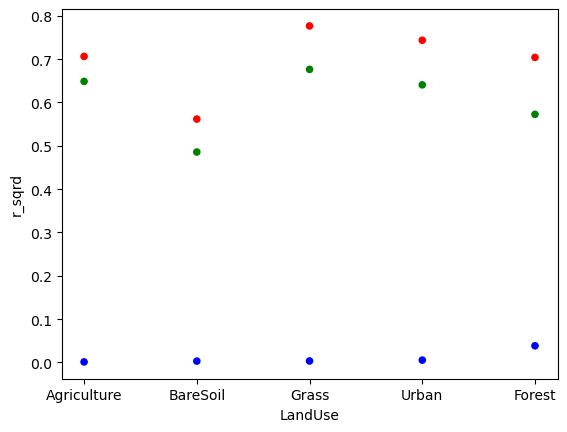

In [51]:
colors = {"WASIM":"blue",
          "SSEB": "red", 
          "EEFlux": "green"}
df.plot.scatter(x = "LandUse", y = "r_sqrd", c = df["Model"].map(colors))

### Correlation Matrix

In [52]:
# Correlation Matrix
ds = xr.Dataset({"SEBAL": eta_day, "WASIM": wasim, 
                     "SSEB": SSEB_raster, "EEFlux": eeflux})

correlation_matrix = ds.to_dataframe().corr()
correlation_matrix = correlation_matrix.iloc[2:6,2:6]
#xr.corr(eta_day, wasim)
correlation_matrix

,SEBAL,WASIM,SSEB,EEFlux
SEBAL,1.000000,0.492508,0.903396,0.886783
WASIM,0.492508,1.000000,0.588903,0.536636
SSEB,0.903396,0.588903,1.000000,0.932672
EEFlux,0.886783,0.536636,0.932672,1.000000


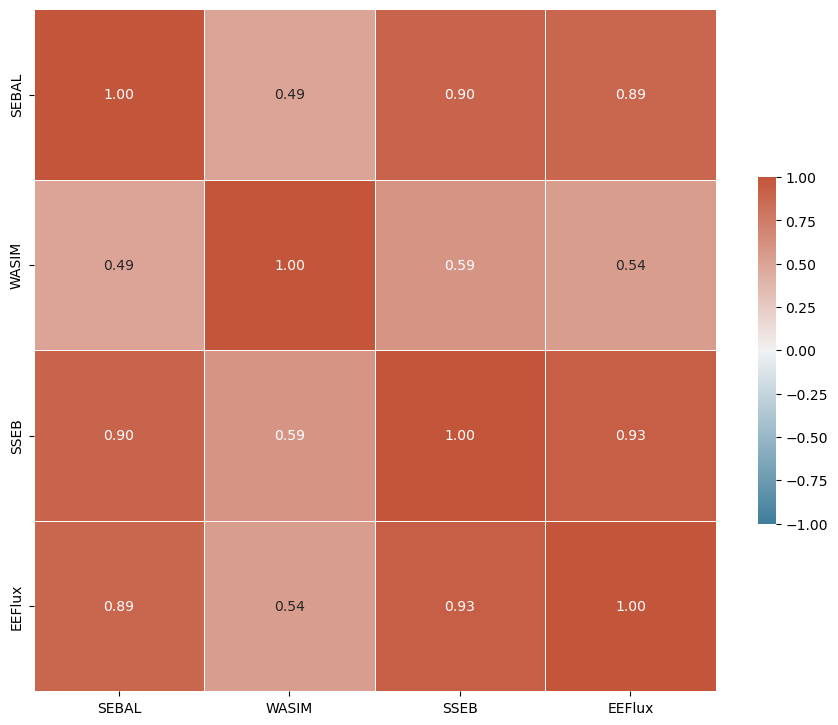

In [53]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the full correlation matrix heatmap with annotations
sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})

# Show the plot
plt.show()